In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pickle
import pandas as pd
from estnltk import Text
import re
import nltk
from nltk import word_tokenize
from multiprocessing import Pool, Manager, Process
import multiprocessing
import time
from scipy import sparse
from scipy.sparse import lil_matrix
from tqdm import tqdm
import numpy as np
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
import gensim
from pandas import DataFrame
from suffix_lemmatizer.suffix_lemmatizer import SuffixLemmatizer

C:\Users\Olha\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#### Load data

In [55]:
with open ('unique_nouns_en', 'rb') as fp:
    unique_nouns_en = pickle.load(fp)
with open ('unique_nouns_et', 'rb') as fp:
    unique_nouns_et = pickle.load(fp)

In [73]:
# -*- coding: utf-8 -*-
en_data = pd.read_csv('en_data.csv', encoding='utf8')
et_data = pd.read_csv('et_data.csv', encoding='utf8')
for i in en_data.columns:
    if 'Unnamed' in i:
        del en_data[i]
for i in et_data.columns:
    if 'Unnamed' in i:
        del et_data[i]

In [74]:
en_data.head()

,link,node,text_join,Nouns
0,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa,AkruFCuFClvuErv One Stroke Phthalo Green ml,AkruFCuFClvuErv Stroke Phthalo Green ml
1,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a,Winter rod AKARA Legend,Winter rod AKARA Legend
2,<http::www.ittgroup.ee::/en/new-products::null...,nodefeb891dd8590e0d85f9c685e4642449,Digital pressure sensor BMP,Digital pressure sensor BMP
3,<http::www.ittgroup.ee::/en/31-converters::nul...,node67109f1f1de73f41d2979d4561221,Analogdigital converter bit ADS,converter bit ADS
4,<http::www.ittgroup.ee::/en/38-prototyping-and...,node3f349ca61d31b5f8c6bfe56bdb8081,Power Charger VA,Power Charger VA


In [75]:
en_data = en_data[~pd.isnull(en_data['Nouns'])]
et_data = et_data[~pd.isnull(et_data['Nouns'])]

In [76]:
def token_clean(sent):
    words = nltk.word_tokenize(sent)
    tokens = [i.lower() for i in words if len(i) > 3 and len(i) < 12]
    return tokens

en_data['Tokens'] = en_data.Nouns.apply(lambda x: token_clean(x))
et_data['Tokens'] = et_data.Nouns.apply(lambda x: token_clean(x))

In [39]:
def reduce_duplicates(data):
    all_nouns = []
    for i in data["Tokens"]:
        for w in i:
            #w = re.sub(r'[^\w\s]','',w)
            all_nouns.append(w)
    uniq = [str(i) for i in all_nouns if len(i) > 3 and len(i) < 10]
    return uniq

nouns_en = reduce_duplicates(en_data)
nouns_et = reduce_duplicates(et_data)

In [69]:
nouns_et_new = []
for word in nouns_et:
    w = word
    w = w.replace('ue', 'ä')
    w = w.replace('ufc', 'ü')
    w = w.replace('kuflakaas', 'külakaas')
    w = w.replace('mufufdud', 'müüdud')
    w = w.replace('uf', 'õ')
    w = w.replace('eestua', 'eesti') 
    w = w.replace('kohetule', 'kohe')
    if w != 'flakses': 
        nouns_et_new.append(w)

### WordCloud

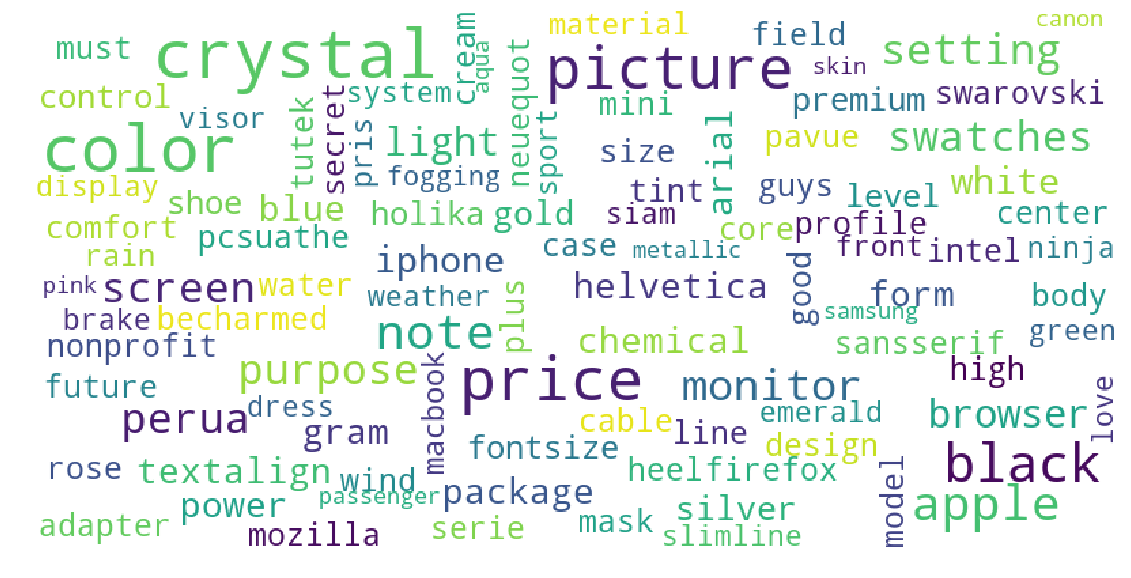

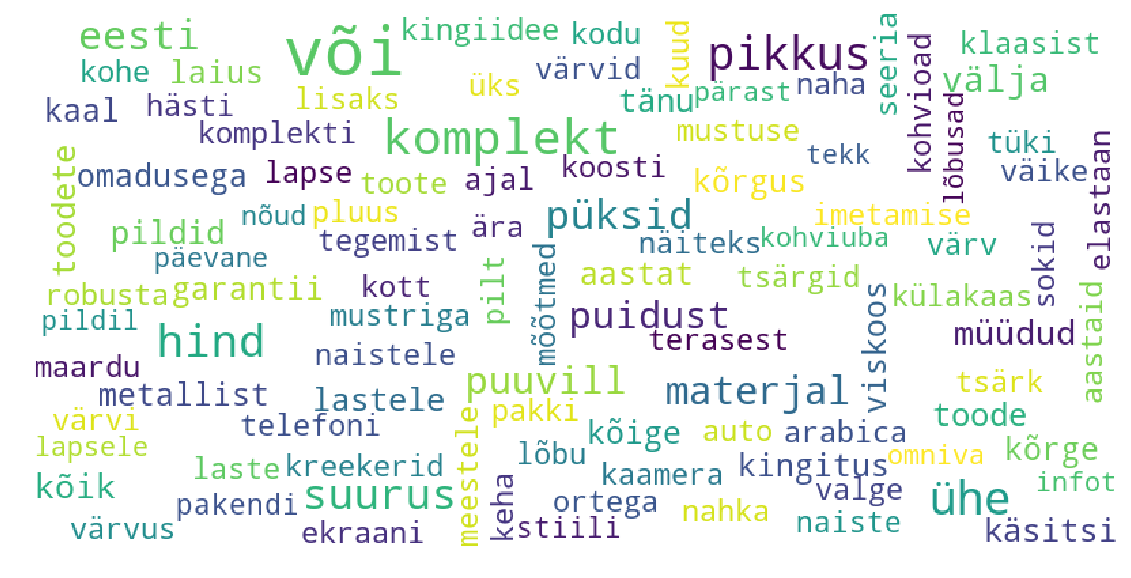

In [70]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

wordcloud = WordCloud(
                        background_color='white',
                        max_words=100,
                        max_font_size=50, 
                        width=800, height=400,
                        collocations = False,
    stopwords=['please'],
                          random_state=42
                         ).generate(' '.join(nouns_en))#re.sub(r'[^\w\s]','',str(set(unique_nouns_en))))

print(wordcloud)

fig = plt.figure(figsize=(20, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

wordcloud = WordCloud(
                        background_color='white',
                        max_words=100,
                        max_font_size=50, 
                        width=800, height=400,
                        collocations = False,
                        random_state=42
                        ).generate(' '.join(nouns_et_new))#re.sub(r'[^\w\s]','',str(set(unique_nouns_et))))
print(wordcloud)

fig = plt.figure(figsize=(20, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### LDA for English

#### 1. Text cleaning

Split text into tokens - words. Lowercase the words and remove punctuation. Remove stopwords and words that have fewer than 3 characters.

In [8]:
def get_tokens(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    exclude = string.punctuation
    new_tokens = [i.lower() for i in tokens if i not in stop_words and i not in exclude and len(i)>2]
    return new_tokens

en_tokens = []
for i in tqdm(unique_nouns_en):
    en_tokens.append(get_tokens(i))

100%|██████████████████████████████████████████████████████████████████████████| 43330/43330 [00:26<00:00, 1644.92it/s]


#### 2. Lemmatization and stemmatization

In [9]:
def lemmas_stemms(words):
    snowball_stemmer = nltk.SnowballStemmer('english')
    wordnet_lemmatizer = WordNetLemmatizer()
    result = []
    for w in words:
        result.append(snowball_stemmer.stem(wordnet_lemmatizer.lemmatize(w)))
    return result

en_stemm = []
for i in tqdm(en_tokens):
    en_stemm.append(lemmas_stemms(i))

100%|██████████████████████████████████████████████████████████████████████████| 43330/43330 [00:10<00:00, 4289.90it/s]


#### 3. Bag of Words

In [10]:
dictionary = gensim.corpora.Dictionary(en_stemm)
dictionary.filter_extremes(no_below=15, no_above=0.5)

In [11]:
bow_corpus = [dictionary.doc2bow(doc) for doc in en_stemm]

In [19]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [13]:
bow_doc_4 = bow_corpus[4]
for i in range(len(bow_doc_4)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4[i][0], 
                                               dictionary[bow_doc_4[i][0]], 
bow_doc_4[i][1]))

Word 11 ("power") appears 1 time.
Word 12 ("charger") appears 1 time.


#### 4. Build LDA model

**Calculate coherence to find optimal value of topic numbres**

In [ ]:
coherence_cv = []
coherence_umass = []
# 434 - 1% of amount of products
for number in tqdm(np.arange(2, 434)):
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=number, id2word=dictionary, passes=2, workers=2)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=en_stemm, dictionary=dictionary, coherence='c_v')
    coherence_cv.append(coherence_model_lda.get_coherence())
    coherence_model_lda = CoherenceModel(model=lda_model, texts=en_stemm, dictionary=dictionary, coherence="u_mass")
    coherence_umass.append(coherence_model_lda.get_coherence())
;

In [52]:
# Save coherence list

with open('coherence_cv.pkl', 'wb') as f:
    pickle.dump(coherence_cv, f)
with open('coherence_umass.pkl', 'wb') as f:
    pickle.dump(coherence_umass, f)

In [12]:
# Load list

with open('coherence_cv.pkl','rb') as f:
     coherence_cv = pickle.load(f)
with open('coherence_umass.pkl', 'rb') as f:
     coherence_umass = pickle.load(f)

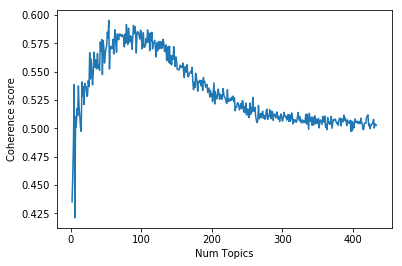

In [47]:
# Show graph

limit=434; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_cv)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

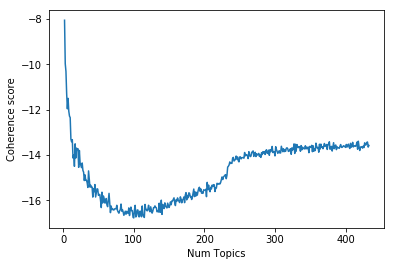

In [55]:
# Show graph

limit=434; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_umass)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [15]:
print('Coherence c_v value: ', max(coherence_cv), ', for number of topics: ', coherence_cv.index(max(coherence_cv))+2)
print('Coherence u_mass value: ', max(coherence_umass), ', for number of topics: ', coherence_umass.index(max(coherence_umass))+2)

Coherence c_v value:  0.5952698059347109 , for number of topics:  54
Coherence u_mass value:  -8.05419584311217 , for number of topics:  2


In [16]:
topic_number = coherence_cv.index(max(coherence_cv))+2

**Build LDA model based on BOW with the best number of topics**

In [17]:
lda_model_bow = gensim.models.LdaMulticore(bow_corpus, num_topics=topic_number, id2word=dictionary, passes=2, workers=2)

In [23]:
# Overview of topics

for idx, topic in lda_model_bow.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.145*"usb" + 0.054*"heat" + 0.048*"hand" + 0.046*"spray" + 0.038*"batteri" + 0.031*"coffe" + 0.029*"micro" + 0.024*"mac" + 0.020*"left" + 0.020*"nut"
Topic: 1 
Words: 0.217*"center" + 0.135*"must" + 0.066*"lock" + 0.038*"textalign" + 0.037*"helvetica" + 0.037*"stylecolor" + 0.025*"door" + 0.025*"profession" + 0.020*"neuequot" + 0.020*"sansserif"
Topic: 2 
Words: 0.108*"bodi" + 0.048*"sata" + 0.047*"pin" + 0.044*"carbon" + 0.038*"type" + 0.035*"seagat" + 0.035*"electrolux" + 0.033*"logitech" + 0.030*"htc" + 0.023*"hdd"
Topic: 3 
Words: 0.170*"iphon" + 0.058*"elit" + 0.041*"origin" + 0.040*"soft" + 0.034*"mbps" + 0.033*"black" + 0.032*"tight" + 0.032*"towel" + 0.030*"robot" + 0.025*"jacket"
Topic: 4 
Words: 0.105*"air" + 0.076*"life" + 0.076*"love" + 0.074*"grey" + 0.050*"fit" + 0.038*"brother" + 0.036*"part" + 0.027*"organ" + 0.024*"citi" + 0.022*"yellow"
Topic: 5 
Words: 0.155*"color" + 0.062*"note" + 0.060*"monitor" + 0.059*"pictur" + 0.058*"screen" + 0.057*"purpos" 

In [107]:
# Define topic for each product

indexes = []
topics = []
for i in en_data.index:    
    doc = en_data.Nouns[i]
    bow_vector = dictionary.doc2bow(lemmas_stemms(get_tokens(doc)))
    for index, score in sorted(lda_model_bow[bow_vector], key=lambda tup: -1*tup[1]):
        indexes.append(index)
        topics.append(lda_model_bow.print_topic(index, 10))
        break

In [108]:
en_data['Topic_bow_index'] = indexes
en_data['Topic_bow'] = topics

**Build LDA model based on TF-IDF with the best number of topics**

In [20]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=topic_number, id2word=dictionary, passes=2, workers=4)

In [67]:
# Overview of topics

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.099*"electrolux" + 0.036*"canon" + 0.036*"drop" + 0.035*"stm" + 0.031*"window" + 0.024*"shift" + 0.021*"retro" + 0.019*"ef" + 0.018*"arm" + 0.017*"kott"
Topic: 1 Word: 0.067*"soni" + 0.043*"duraac" + 0.042*"lock" + 0.026*"kleit" + 0.025*"premium" + 0.024*"hama" + 0.022*"swarovski" + 0.020*"xperia" + 0.019*"perform" + 0.018*"matur"
Topic: 2 Word: 0.132*"plus" + 0.045*"pool" + 0.030*"daili" + 0.027*"chain" + 0.021*"nfc" + 0.018*"measur" + 0.016*"protector" + 0.016*"ace" + 0.016*"whey" + 0.014*"nufudepesumasin"
Topic: 3 Word: 0.036*"quadralit" + 0.029*"bluetooth" + 0.026*"video" + 0.022*"valvolin" + 0.022*"clean" + 0.021*"fit" + 0.021*"advanc" + 0.019*"cherri" + 0.017*"gtx" + 0.017*"speick"
Topic: 4 Word: 0.136*"must" + 0.096*"black" + 0.044*"mask" + 0.040*"red" + 0.031*"iphon" + 0.028*"citi" + 0.024*"multi" + 0.021*"iron" + 0.020*"iii" + 0.018*"vuerv"
Topic: 5 Word: 0.072*"basic" + 0.043*"mare" + 0.032*"activ" + 0.027*"vbrake" + 0.023*"shoe" + 0.021*"pr" + 0.020*"violet"

In [110]:
# Define topic for each product

indexes = []
topics = []
for i in en_data.index:    
    doc = en_data.Nouns[i]
    bow_vector = dictionary.doc2bow(lemmas_stemms(get_tokens(doc)))
    for index, score in sorted(lda_model_tfidf[bow_vector], key=lambda tup: -1*tup[1]):
        indexes.append(index)
        topics.append(lda_model_bow.print_topic(index, 10))
        break

In [111]:
en_data['Topic_tfidf_index'] = indexes
en_data['Topic_tfidf'] = topics

In [112]:
en_data.head()

,link,node,text_join,Nouns,Tokens,Topic_bow_index,Topic_bow,Topic_tfidf_index,Topic_tfidf
0,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa,AkruFCuFClvuErv One Stroke Phthalo Green ml,AkruFCuFClvuErv Stroke Phthalo Green ml,"[stroke, phthalo, green]",6,"0.124*""light"" + 0.073*""rose"" + 0.063*""digit"" +...",0,"0.145*""usb"" + 0.054*""heat"" + 0.048*""hand"" + 0...."
1,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a,Winter rod AKARA Legend,Winter rod AKARA Legend,"[winter, akara, legend]",18,"0.231*""led"" + 0.108*""set"" + 0.087*""philip"" + 0...",44,"0.157*""seri"" + 0.052*""plate"" + 0.035*""fabric"" ..."
2,<http::www.ittgroup.ee::/en/new-products::null...,nodefeb891dd8590e0d85f9c685e4642449,Digital pressure sensor BMP,Digital pressure sensor BMP,"[digital, pressure, sensor]",36,"0.081*""fragranc"" + 0.079*""system"" + 0.048*""not...",35,"0.105*""blue"" + 0.073*""royal"" + 0.063*""dress"" +..."
3,<http::www.ittgroup.ee::/en/31-converters::nul...,node67109f1f1de73f41d2979d4561221,Analogdigital converter bit ADS,converter bit ADS,[converter],2,"0.108*""bodi"" + 0.048*""sata"" + 0.047*""pin"" + 0....",24,"0.140*""mini"" + 0.057*""design"" + 0.044*""home"" +..."
4,<http::www.ittgroup.ee::/en/38-prototyping-and...,node3f349ca61d31b5f8c6bfe56bdb8081,Power Charger VA,Power Charger VA,"[power, charger]",0,"0.145*""usb"" + 0.054*""heat"" + 0.048*""hand"" + 0....",1,"0.217*""center"" + 0.135*""must"" + 0.066*""lock"" +..."


In [113]:
en_data.to_csv('Results/en_data_lda.csv')

**Visualzation**

In [21]:
import pyLDAvis.gensim
corpus = [dictionary.doc2bow(doc) for doc in en_stemm]
vis = pyLDAvis.gensim.prepare(lda_model_bow, corpus, dictionary)
pyLDAvis.display(vis)

In [22]:
import pyLDAvis.gensim
corpus = [dictionary.doc2bow(doc) for doc in en_stemm]
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus, dictionary)
pyLDAvis.display(vis)

### LDA for Estonian

#### 1. Text cleaning

In [8]:
f = open("estonian-stopwords.txt", "r")
stop_words = f.read()

def get_tokens(text, stop_words):
    tokens = text.split(' ')
    exclude = string.punctuation
    new_tokens = [i.lower() for i in tokens if i not in stop_words and i not in exclude and len(i)>2]
    return new_tokens

et_tokens = []
for i in tqdm(unique_nouns_et):
    et_tokens.append(get_tokens(i, stop_words))

100%|██████████████████████████████████████████████████████████████████████████| 31043/31043 [00:23<00:00, 1303.88it/s]


#### 2. Lemmatization and stemmatization

In [20]:
def lemmas_stemms(words):
    result = []
    for w in words:
        text = Text(w)
        result.append(text.lemmas[0])
    return result

et_stemm = []
for i in et_tokens:
    et_stemm.append(lemmas_stemms(i))

#### 3. Bag of Words

In [25]:
dictionary = gensim.corpora.Dictionary(et_stemm)
dictionary.filter_extremes(no_below=15, no_above=0.5)

In [26]:
bow_corpus = [dictionary.doc2bow(doc) for doc in et_stemm]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

#### 4. Build LDA model

**Calculate coherence to find optimal value of topic numbres**

In [30]:
coherence_cv = []
coherence_umass = []
# 310 - 1% of amount of products
for number in tqdm(np.arange(2, 310)):
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=number, id2word=dictionary, passes=2, workers=2)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=et_stemm, dictionary=dictionary, coherence='c_v')
    coherence_cv.append(coherence_model_lda.get_coherence())
    coherence_model_lda = CoherenceModel(model=lda_model, texts=et_stemm, dictionary=dictionary, coherence="u_mass")
    coherence_umass.append(coherence_model_lda.get_coherence())
;



  0%|                                                                                          | 0/308 [00:00<?, ?it/s]

  0%|▎                                                                               | 1/308 [00:37<3:12:55, 37.70s/it]

  1%|▌                                                                               | 2/308 [01:13<3:09:09, 37.09s/it]

  1%|▊                                                                               | 3/308 [01:47<3:04:38, 36.32s/it]

  1%|█                                                                               | 4/308 [02:23<3:02:39, 36.05s/it]

  2%|█▎                                                                              | 5/308 [03:00<3:04:28, 36.53s/it]

  2%|█▌                                                                              | 6/308 [03:33<2:57:43, 35.31s/it]

  2%|█▊                                                                              | 7/308 [04:06<2:53:46, 34.64s/it]

  3%|██                       

 44%|█████████████████████████████████                                           | 134/308 [2:25:16<4:15:21, 88.06s/it]

 44%|█████████████████████████████████▎                                          | 135/308 [2:26:47<4:15:57, 88.77s/it]

 44%|█████████████████████████████████▌                                          | 136/308 [2:28:17<4:16:08, 89.35s/it]

 44%|█████████████████████████████████▊                                          | 137/308 [2:29:49<4:16:16, 89.92s/it]

 45%|██████████████████████████████████                                          | 138/308 [2:31:21<4:16:38, 90.58s/it]

 45%|██████████████████████████████████▎                                         | 139/308 [2:32:53<4:16:50, 91.19s/it]

 45%|██████████████████████████████████▌                                         | 140/308 [2:34:26<4:16:54, 91.75s/it]

 46%|██████████████████████████████████▊                                         | 141/308 [2:36:00<4:17:04, 92.36s/it]

 46%|███████████████████████████

 87%|█████████████████████████████████████████████████████████████████▎         | 268/308 [6:41:34<1:20:44, 121.12s/it]

 87%|█████████████████████████████████████████████████████████████████▌         | 269/308 [6:43:34<1:18:21, 120.55s/it]

 88%|█████████████████████████████████████████████████████████████████▋         | 270/308 [6:45:33<1:16:08, 120.23s/it]

 88%|█████████████████████████████████████████████████████████████████▉         | 271/308 [6:47:32<1:13:56, 119.90s/it]

 88%|██████████████████████████████████████████████████████████████████▏        | 272/308 [6:49:32<1:11:51, 119.77s/it]

 89%|██████████████████████████████████████████████████████████████████▍        | 273/308 [6:51:31<1:09:51, 119.75s/it]

 89%|██████████████████████████████████████████████████████████████████▋        | 274/308 [6:53:34<1:08:17, 120.50s/it]

 89%|██████████████████████████████████████████████████████████████████▉        | 275/308 [6:55:34<1:06:14, 120.43s/it]

 90%|███████████████████████████

''

In [31]:
# Save coherence list

with open('est_coherence_cv.pkl', 'wb') as f:
    pickle.dump(coherence_cv, f)
with open('est_coherence_umass.pkl', 'wb') as f:
    pickle.dump(coherence_umass, f)

In [ ]:
# Load list

with open('est_coherence_cv.pkl','rb') as f:
     coherence_cv = pickle.load(f)
with open('est_coherence_umass.pkl', 'rb') as f:
     coherence_umass = pickle.load(f)

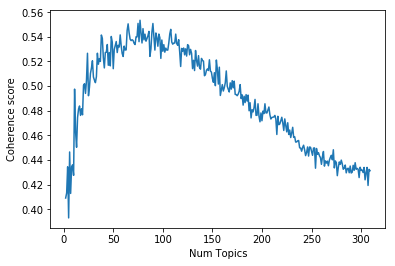

In [33]:
# Show graph

limit=310; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_cv)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

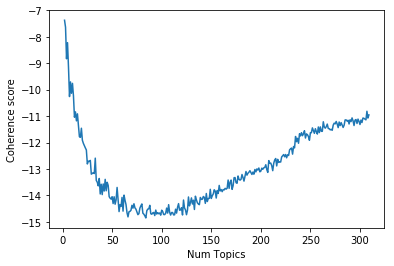

In [34]:
# Show graph

limit=310; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_umass)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [35]:
print('Coherence c_v value: ', max(coherence_cv), ', for number of topics: ', coherence_cv.index(max(coherence_cv))+2)
print('Coherence u_mass value: ', max(coherence_umass), ', for number of topics: ', coherence_umass.index(max(coherence_umass))+2)

Coherence c_v value:  0.5535195246447859 , for number of topics:  77
Coherence u_mass value:  -7.37134992421791 , for number of topics:  2


In [36]:
topic_number = coherence_cv.index(max(coherence_cv))+2

**Build LDA model based on BOW with the best number of topics**

In [38]:
lda_model_bow = gensim.models.LdaMulticore(bow_corpus, num_topics=topic_number, id2word=dictionary, passes=2, workers=2)

In [53]:
def lemmas_stemms(words):
    result = []
    for w in words:
        text = Text(w)
        result.append(text.lemmas[0])
    return result

doc = et_data.Nouns[1]
print(doc)
print(get_tokens(doc, stop_words))
print(lemmas_stemms(get_tokens(doc, stop_words)))
print(dictionary.doc2bow(lemmas_stemms(get_tokens(doc, stop_words))))

aiamuFuFbel lossipargi stiilis
['aiamufufbel', 'lossipargi', 'stiilis']
['aiamufufbel', 'lossipark', 'stiil']
[(0, 1), (1, 1)]


In [54]:
# Define topic for each product

f = open("estonian-stopwords.txt", "r")
stop_words = f.read()

def get_tokens(text, stop_words):
    tokens = text.split(' ')
    exclude = string.punctuation
    new_tokens = [i.lower() for i in tokens if i not in stop_words and i not in exclude and len(i)>2]
    return new_tokens

indexes = []
topics = []
for i in et_data.index:    
    doc = et_data.Nouns[i]
    bow_vector = dictionary.doc2bow(lemmas_stemms(get_tokens(doc, stop_words)))
    for index, score in sorted(lda_model_bow[bow_vector], key=lambda tup: -1*tup[1]):
        indexes.append(index)
        topics.append(lda_model_bow.print_topic(index, 10))
        break

In [55]:
et_data['Topic_bow_index'] = indexes
et_data['Topic_bow'] = topics

**Build LDA model based on TF-IDF with the best number of topics**

In [56]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=topic_number, id2word=dictionary, passes=2, workers=4)

In [58]:
# Define topic for each product

indexes = []
topics = []
for i in et_data.index:    
    doc = et_data.Nouns[i]
    bow_vector = dictionary.doc2bow(lemmas_stemms(get_tokens(doc, stop_words)))
    for index, score in sorted(lda_model_tfidf[bow_vector], key=lambda tup: -1*tup[1]):
        indexes.append(index)
        topics.append(lda_model_bow.print_topic(index, 10))
        break

In [59]:
et_data['Topic_tfidf_index'] = indexes
et_data['Topic_tfidf'] = topics

In [60]:
et_data.head()

,link,node,text_join,Nouns,Tokens,Topic_bow_index,Topic_bow,Topic_tfidf_index,Topic_tfidf
0,<http::tamberi.eu::/73-ehtekaardid::null::2017...,node6883b5caa683772129c48f93ac5e99,Ehtekaart,Ehtekaart,[ehtekaart],0,"0.058*""ratas"" + 0.050*""peenis"" + 0.036*""kueevu...",0,"0.058*""ratas"" + 0.050*""peenis"" + 0.036*""kueevu..."
1,<https::www.paradiis.ee::/et/128-kampaania::p=...,noded2b1c726cca5417aadf2c82e333d51b6,See esinduslik aiamuFuFbel on valmistatud rom...,aiamuFuFbel lossipargi stiilis,"[aiamufufbel, lossipargi, stiilis]",13,"0.187*""must"" + 0.095*""kohvipadi"" + 0.041*""kree...",43,"0.223*""kott"" + 0.117*""naine"" + 0.080*""canon"" +..."
2,<https::aiakaubad.ee::/84-telgid::null::201708...,nodeaeeb8b6ba62b6f3fd2eafc75ce1f36c,Alumiiniumtoru luEbimuFuFt uD uAuDcm uDClemis...,Alumiiniumtoru luEbimuFuFt uAuDcm uDClemised t...,"[luebimufuft, uaudcm, udclemised, torud, udmm,...",75,"0.055*""rind"" + 0.044*""puhastamine"" + 0.038*""pi...",69,"0.094*""pikkus"" + 0.060*""otsik"" + 0.050*""hari"" ..."
3,<https::vibes.ee::/et/13-vibraatorid::null::20...,node38302f399536504988c1d1b4703df497,Nutikas sensoriga armukuul mida saad juhtida a...,sensoriga armukuul treening lelu aru lihased t...,"[sensoriga, armukuul, treening, lelu, lihased,...",29,"0.145*""kufclmkapp"" + 0.060*""kinnas"" + 0.059*""k...",16,"0.112*""orte"" + 0.109*""kuflakaas"" + 0.081*""maha..."
4,<https::vibes.ee::/et/750-vibraatormunad::null...,node8a81eac4ed95140bdb38ef9291fb4c8,Juhtmevaba pildiga vibraatormuna millega omale...,pildiga vibraatormuna omale vuFi naudingut pak...,"[pildiga, omale, vufi, naudingut, armukuul, sh...",27,"0.046*""patarei"" + 0.045*""uokolaad|uokolaat"" + ...",18,"0.111*""koostis"" + 0.056*""ufhu"" + 0.038*""pluus""..."


In [61]:
et_data.to_csv('Results/et_data_lda.csv')

**Visualzation**

In [62]:
import pyLDAvis.gensim
corpus = [dictionary.doc2bow(doc) for doc in et_stemm]
vis = pyLDAvis.gensim.prepare(lda_model_bow, corpus, dictionary)
pyLDAvis.display(vis)

In [63]:
import pyLDAvis.gensim
corpus = [dictionary.doc2bow(doc) for doc in et_stemm]
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus, dictionary)
pyLDAvis.display(vis)